## Introduction ##

This notebook is designed to simulate the general layer percolation process. 

In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Layer Percolation Simulation ##

In [2]:
#Function for offsetting shape associated to each cell
def get_offsets(right_offset, cell, shape):
    offset_cells = []
    for shape_cell in shape:
        #For each cell in the shape, take the right coordinate from the shape, take the sleep coordinate from both the shape and the cell
        offset_cells.append(tuple(np.array([shape_cell[0], shape_cell[1]])+np.array([right_offset, cell[1]])))
    return offset_cells

In [3]:
#Function to determine the width of a shape
def width(shape):
    width = 0
    for cell in shape:
        if cell[0] > width:
            width = cell[0]
    return width+1

In [4]:
#This function takes in an unordered array of cells and partitions it into an array of diagonals. 
def partition_into_layers(newly_invaded_cells):
    flat_list = []
    num_layers = 0
    for list in newly_invaded_cells:
        for element in list:
            #Find the largest layer in the set of newly invaded cells
            if element[0]+element[1] > num_layers:
                num_layers = element[0]+element[1]
            flat_list.append(element)

    invaded_layers = []
    
    for layer in range(num_layers+1):
        layer_i = []
        for cell in flat_list:
            #Only add a cell if it's not already in the layer, so we are not keeping repeat cells
            if cell[0]+cell[1] == layer and (cell[0], cell[1]) not in layer_i:
                layer_i.append((cell[0], cell[1]))
        invaded_layers.append(layer_i)   
    return invaded_layers

In [16]:
def max_height(invaded_cells):
    max_height = 0
    for diag in invaded_cells:
        for cell in diag:
            if cell[-1] > max_height:
                max_height = cell[-1]
    return max_height

In [5]:
#This function specifies a law used to generate shapes. 
#The default law is the comb percolation law. 
#Use mode custom to implement a custom law. Note if you require more dependency between shapes than that of comb percolation
#you will need to refactor this code. 
def law(sleep_rate, inheritance_indicator, mode ='comb'):
    match mode:
        case 'one':
            shape = one_law()
        case 'domino':
            shape = domino_law()
        case 'interval':
            shape = interval_law(sleep_rate)
        case 'comb':
            [shape, new_inheritance_indicator] = comb_law(sleep_rate, inheritance_indicator)
        case 'custom':
            shape = custom_law()

    if mode != 'comb':
        new_inheritance_indicator = inheritance_indicator

    return [shape, new_inheritance_indicator]

In [6]:
def one_law():
    shape = [(0,0),(1,0),(2,0),(1,1),(1,2),(0,2)]
    return shape

In [7]:
def domino_law():
    if random.getrandbits(1):
        shape = [(0,0), (1,0)]
    else:
        shape = [(0,0),(0,1)]
    return shape

In [8]:
def interval_law(sleep_rate):
    shape = []
    R = np.random.geometric(1/2) #np geometric is supported on {1,2,...}, so no need to add 1 here.
    for i in range(R):
        shape.append((i,0))
        if np.random.rand() < sleep_rate/(1+sleep_rate):
            shape.append((i,1))
    return shape

In [9]:
def comb_law(sleep_rate, inheritance_indicator):
    shape = []
    U = np.random.geometric(1/2) #np geometric is supported on {1,2,...}, so no need to add 1 here.
    r_counter = 0
    for i in range(U):
        R_i = np.random.geometric(2/3) #np geometric is supported on {1,2,...}, so no need to add 1 here.
        if i == 0:
            T = inheritance_indicator
        else:
            if np.random.rand() < sleep_rate/(1+sleep_rate):
                T = 1
            else:
                T = 0
    
        for j in range(R_i):
            s = np.random.rand()
            if s < sleep_rate/(1+sleep_rate):
                S = 1
            else:
                S = 0
            #Don't want repeat cells added to the shape for performance. 
            for tuple in {(r_counter, 0), (r_counter, S), (r_counter, T), (r_counter, S+T)}:
                if tuple not in shape:
                    shape.append(tuple)
            r_counter += 1
        r_counter -= 1 #We overcounted the number of rights executed. 
                
    new_inheritance_indicator = T
    return [shape, new_inheritance_indicator]

In [10]:
#Modify this function if you want to simulate a custom law. 
def custom_law():
    shape = [(0,0)]
    return shape

In [11]:
#This function takes in a set of invaded cells separated into diagonals and a sleep rate, 
#and returns an array of newly invaded cells after one step of the layer percolation process. 
#The returned array of newly invaded cells is separated into diagonals already
def run_layer_percolation_step(invaded_cells, sleep_rate, mode = 'comb'):
    newly_invaded_cells = []
    #Assumes invaded_cells is an array of diagonals containing cells
    num_layers = len(invaded_cells)
    shape_array = []
    right_offset = 0
    if mode == 'comb':
        if np.random.rand() < sleep_rate/(1+sleep_rate):
            inheritance_indicator = 1
        else:
            inheritance_indicator = 0
    else:
        inheritance_indicator = None
    for i in range(num_layers):
        #For each diagonal, generate a shape from the law
        [shape_i, inheritance_indicator] = law(sleep_rate, inheritance_indicator, mode)
        #Add it to the list of shapes
        shape_array.append(shape_i)
    for i, diagonal in enumerate(invaded_cells):
        shape_i = shape_array[i]
        for cell in diagonal:
            offset_cells = get_offsets(right_offset, cell, shape_i)
            newly_invaded_cells.append(offset_cells)
        #Layers are formed with overlap of 1
        right_offset += width(shape_i)-1
    newly_invaded_cells = partition_into_layers(newly_invaded_cells)
    return newly_invaded_cells

## Running Simulations for Lower Bound ## 

In [49]:
def simulate_lower_bound(sleep_rate, num_iters):
    total_height = 0
    if sleep_rate == 0:
        return 0
    #Run num_iters trials
    for i in range(num_iters):
        print(i+1, end="\r")
        #For each trial choose a number of steps K~Geo(sleep_rate/(1+sleep_rate))
        K = np.random.geometric(sleep_rate/(1+sleep_rate))
        invaded_cells = partition_into_layers([[(0,0)]])
        #Run the layer percolation process over K steps.
        for k in range(K):
            invaded_cells = run_layer_percolation_step(invaded_cells, 3*sleep_rate/2, mode = 'interval')
        #Find the height of the highest cell in the infected component of (0,0)_0 at step K
        height = max_height(invaded_cells)
        total_height += height
    #Lower bound is one more than the average height of these trials, all scaled by sleep_rate/(1+sleep_rate) 
    return sleep_rate/(1+sleep_rate)*(1+total_height/num_iters)

## Comb and Interval ARW Simulation ##

In [28]:
#Helper method for choosing 1 of 3 options. This is called a lot so we want it to be fast. 
def rand3():
    #Find a random integer from 0,1,2. Supposedly fast?
    while True:
        r = random.getrandbits(2)
        if r < 3:
            return r

In [29]:
#Function for adding a particle to the interval. Returns true only if the particle fell into a sink. 
def add_particle_to_interval(interval, index_col):
    length = interval.shape[0]
    #If the index we want to move to is outside the length of the interval, we moved into a sink, so do nothing
    if index_col >= length or index_col< 0:
        #If the particle fell off, we want to find a new active particle
        return True
    #If the site we moved into has a sleeping particle, wake it up so we have 2 sleeping particles in it. 
    elif interval[index_col] == -1:
        interval[index_col] = 2
        #We can keep tracking this active particle.
        return False
    #Otherwise we have one more sleeping particle. 
    else:
        interval[index_col] += 1
        #We can keep tracking this active particle.
        return False

In [30]:
#Function for stabalizing the interval, returns nothing but changes the interval array passed as an argument
def stabalize_interval(interval, sleep_rate):
    #We begin by searching for the index of an active particle
    searching_for_index = True
    #Loop while there are still active particles in the interval
    while(True):
        #If we are not already tracking an active particle, look for a new one
        if searching_for_index:
            #Find the index of the first site with at least one active particle. If no such index exists we are stable, and so exit. 
            positive_indices = np.flatnonzero(interval > 0)
            if positive_indices.size > 0:
                active_index = positive_indices[0]
                #Found a new active particle to track
                searching_for_index = False
            else:
                return interval

        #If only one particle is in the active site, it can fall asleep 
        if interval[active_index] == 1:
            #r is drawn uniformly from (0,1)
            r = random.random()
            #If r is small enough (< lambda/(1+lambda)) the particle falls alseep
            if r < sleep_rate/(1+sleep_rate):
                #Particle is asleep, so the value at the site is -1
                interval[active_index] = -1
                #Particle fell asleep, so need to find new active particle to track
                searching_for_index = True
            else:
                #If our only active particle moved, we set the entry in the site to 0
                interval[active_index] = 0
                #Pick a random direction
                if bool(random.getrandbits(1)):
                    #Moved to the right, so increment the index by 1
                    active_index += 1
                    searching_for_index = add_particle_to_interval(interval, active_index)
                else:
                    #Moved to the left, so decrement the index by 1
                    active_index -= 1
                    searching_for_index = add_particle_to_interval(interval, active_index)
        #If multiple active particles, one must move
        else:  
            #Particle moved so reduce the number by 1
            interval[active_index] -= 1
            #Move right
            if bool(random.getrandbits(1)):
                active_index += 1
                searching_for_index = add_particle_to_interval(interval, active_index)
            #Move left
            else:
                active_index -= 1
                searching_for_index = add_particle_to_interval(interval, active_index)

In [31]:
def run_simulation_interval(interval_length, sleep_rate, num_trials):
    #Start with an estimate of 0 for the density. 
    interval_density = 0
    #The interval begins with active particles at each site
    interval = np.ones(interval_length)
    #Progress bar so we know about how long things will take
    for _ in tqdm(range(num_trials), desc=f"Running trials (L={interval_length}, r={sleep_rate})", leave=False):
        stabalize_interval(interval, sleep_rate)
        #The density is the number of sleeping particles divided by the length, sleeping particles are represented by -1
        #-= as we are summing -1 for each sleeping particle left
        interval_density -= np.sum(interval)/interval_length
        #Add an active particle in the center. 
        add_particle_to_interval(interval, int(interval_length/2))
    #Return the average density over the trials
    return interval_density/num_trials

In [32]:
def generate_data_interval(interval_lengths, sleep_rates, num_trials_each):
    data = np.zeros((len(interval_lengths), len(sleep_rates)))
    #Loop over parameters and run simulations
    for i, length in enumerate(interval_lengths):
        for j, sleep_rate in enumerate(sleep_rates):
            data[i, j] = run_simulation_interval(length, sleep_rate, num_trials_each)
    return data

In [33]:
#Function for adding particle to the comb. Returns true only if the particle fell into a sink 
def add_particle_to_comb(comb, index_row, index_col):
    length = comb.shape[1]
    #If the index we want to move to is outside the length of the comb, we moved into a sink, so do nothing
    if index_col >= length or index_col< 0:
        #If the particle fell off, we want to find a new active particle
        return True
    #If the site we moved into has a sleeping particle, wake it up so we have 2 sleeping particles in it. 
    elif comb[index_row, index_col] == -1:
        comb[index_row, index_col] = 2
        #We can keep tracking this active particle.
        return False
    #Otherwise we have one more sleeping particle. 
    else:
        comb[index_row, index_col] += 1
        #We can keep tracking this active particle.
        return False

In [34]:
def sample_stationary_distribution_comb(comb, sleep_rate):
    #Start out searching for an active particle
    searching_for_index = True
    while(True):
        #This is expensive, so don't want to run it unless we have to
        if searching_for_index:
            #Find the index of the first site with at least one active particle. If no such index exists we are stable, and so exit. 
            positive_indices = np.flatnonzero(comb > 0)
            if positive_indices.size > 0:
                active_index = np.unravel_index(positive_indices[0], comb.shape)
                #Once we find an active particle, want to keep tracking it until it falls off or falls asleep
                searching_for_index = False
            else:
                return comb
        #If only one particle is in the active site, it can fall asleep 
        if comb[active_index] == 1:
            r = random.random()
            #Entry of -1 means sleeping particle
            if r < sleep_rate/(1+sleep_rate):
                comb[active_index] = -1
                #If a particle falls alseep, we want to find a new active particle to track
                searching_for_index = True
            else:
                #If our only active particle moved, we set the entry in the site to 0
                comb[active_index] = 0
                #If we are in the tooth, the only place to go is down
                if active_index[0] == 0:
                    active_index = (active_index[0] + 1, active_index[1])
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                else:
                    #Otherwise pick a random direction to move in
                    direction = rand3()
                    #Move up
                    if direction == 0:
                        active_index = (active_index[0] - 1, active_index[1])
                        searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                    #Move right
                    elif direction == 1:
                        active_index = (active_index[0], active_index[1] + 1)
                        searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                    #Move left
                    elif direction == 2:
                        active_index = (active_index[0], active_index[1] - 1)
                        searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
        #If multiple active particles, one must move
        else:  
            #Particle moved so reduce the number by 1
            comb[active_index] -= 1
            #If in the tooth must move down. 
            if active_index[0] == 0:
                    active_index = (active_index[0] + 1, active_index[1])
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
            else:
                #Pick a random direction to move
                direction = rand3()
                if direction == 0:
                    active_index = (active_index[0] - 1, active_index[1])
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                elif direction == 1:
                    active_index = (active_index[0], active_index[1] + 1)
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                elif direction == 2:
                    active_index = (active_index[0], active_index[1] - 1)
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])

In [35]:
def run_simulation_comb(comb_length, sleep_rate, num_trials):
    #Record these densities seperately
    tooth_density = 0
    spine_density = 0
    comb = np.ones((2, comb_length))
    for _ in tqdm(range(num_trials), desc=f"Running trials (L={comb_length}, r={sleep_rate})", leave=False):
        sample_stationary_distribution_comb(comb, sleep_rate)
        #Minus as we are summing -1 for each sleeping particle left
        tooth_density -= np.sum(comb[0])/comb_length
        spine_density -= np.sum(comb[1])/comb_length
        #Add a particle in row 1 (the spine) in the center. 
        add_particle_to_comb(comb, 1, int(comb_length/2))
    return [tooth_density / num_trials, spine_density/num_trials]

In [36]:
def generate_data_comb(comb_lengths, sleep_rates, num_trials_each):
    data = np.zeros((len(comb_lengths), len(sleep_rates), 2))
    for i, length in enumerate(comb_lengths):
        for j, sleep_rate in enumerate(sleep_rates):
            data[i, j, :] = run_simulation_comb(length, sleep_rate, num_trials_each)
    return data

## Running Simulations ## 

In [50]:
comb_lengths = [250]
sleep_rates = np.arange(0, 1.05, 0.1)
num_trials = 1000
comb_data = generate_data_comb(comb_lengths, sleep_rates, num_trials)
interval_data = generate_data_interval(comb_lengths, 3*sleep_rates/2, num_trials)
lower_bound_data = []
for rate in sleep_rates:
    lower_bound_data.append(simulate_lower_bound(rate, num_trials))

In [55]:
np.savez('comb_ARW_bound_simulation_data', comb_data=comb_data, upper_bound_data=1+interval_data, lower_bound_data = lower_bound_data)

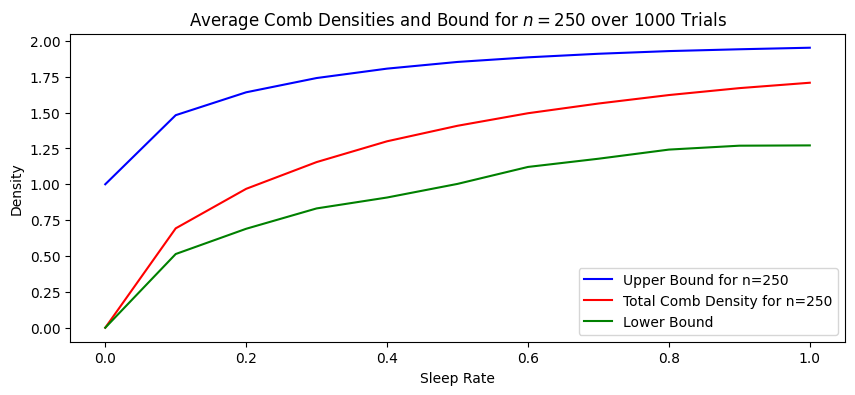

In [54]:
plt.figure(figsize=(10, 4))

plt.plot(sleep_rates, 1+interval_data[0, :], color='b', label='Upper Bound for n=250')
plt.plot(sleep_rates, comb_data[0, :, 0]+comb_data[0, :, 1], color='r', label='Total Comb Density for n=250')
plt.plot(sleep_rates, lower_bound_data, color='g', label='Lower Bound')


plt.xlabel("Sleep Rate")
plt.ylabel("Density")
plt.title("Average Comb Densities and Bound for $n=250$ over 1000 Trials")

plt.legend()
plt.savefig('ARW_Density_Bound_Comparison.png', bbox_inches='tight', dpi=300)
plt.show()

plt.close()